# 💥 Berefore you run this notebook, start the PostgreSQL db service!

## 📨 Load Data into PostgreSQL DB

In [22]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd

DB_HOST = "localhost"
DB_NAME = "postgres"
DB_USER = "postgres"
DB_PASSWORD = "postgres"
DB_PORT = "5401"

In [23]:
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

try:
    # Connect to the db to ensure connection is working
    conn_test = psycopg2.connect(
        host=DB_HOST,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
        port=DB_PORT
    )
    conn_test.close()
    print("Successfully connected to PostgreSQL database!")

    # Load DataFrames
    payments_df = pd.read_csv('Payments.csv')
    clients_df = pd.read_csv('Clients.csv')

    # IMPORTANT: Convert 'transaction_date' from EPOCH to datetime BEFORE loading to DB, in order to have it as a proper timestamp
    payments_df['transaction_date'] = pd.to_datetime(payments_df['transaction_date'], unit='s')


    # Write DataFrames to PostgreSQL tables
    # if_exists: 'replace' will drop the table if it exists and recreate it
    # index=False: Do not write the DataFrame index as a column in the database table

    print("Importing Payments DataFrame to 'payments' table...")
    payments_df.to_sql('payments', engine, if_exists='replace', index=False)
    print("Payments data imported successfully!")

    print("Importing Clients DataFrame to 'clients' table...")
    clients_df.to_sql('clients', engine, if_exists='replace', index=False)
    print("Clients data imported successfully!")

except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Close the engine connection
    engine.dispose()

Successfully connected to PostgreSQL database!
Importing Payments DataFrame to 'payments' table...
Payments data imported successfully!
Importing Clients DataFrame to 'clients' table...
Clients data imported successfully!


## 📩 Load Data from PostgreSQL DB

In [24]:
engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

try:
    # Read data back from PostgreSQL into pandas DataFrames
    payments_df_from_db = pd.read_sql('SELECT * FROM payments', engine)
    clients_df_from_db = pd.read_sql('SELECT * FROM clients', engine)

    print("Data successfully loaded from PostgreSQL into DataFrames for analysis.")
    print("\nPayments DataFrame (from DB) - first 5 rows:")
    print(payments_df_from_db.head().to_markdown(index=False, numalign="left", stralign="left"))
    print("\nClients DataFrame (from DB) - first 5 rows:")
    print(clients_df_from_db.head().to_markdown(index=False, numalign="left", stralign="left"))

except Exception as e:
    print(f"Error loading data from database: {e}")
finally:
    engine.dispose()

Data successfully loaded from PostgreSQL into DataFrames for analysis.

Payments DataFrame (from DB) - first 5 rows:
| transaction_id   | contract_id   | client_id   | transaction_date    | payment_amt   | payment_code   |
|:-----------------|:--------------|:------------|:--------------------|:--------------|:---------------|
| 20175            | 927           | 1           | 2018-05-22 18:08:31 | 66.66         | PAYMENT        |
| 8485             | 927           | 1           | 2017-11-26 17:08:15 | 66.66         | PAYMENT        |
| 13778            | 927           | 1           | 2018-02-22 17:08:23 | 66.66         | PAYMENT        |
| 22768            | 927           | 1           | 2018-06-24 18:08:44 | 66.66         | PAYMENT        |
| 15698            | 927           | 1           | 2018-03-22 17:08:24 | 66.66         | PAYMENT        |

Clients DataFrame (from DB) - first 5 rows:
| client_id   | entity_type                | entity_year_established   |
|:------------|:-------

## 🧼 Check Data is Clean

In [25]:
total_payments = payments_df_from_db.shape[0]
total_clients = clients_df_from_db.shape[0]

# Payments DataFrame: Check and list duplicate Transaction IDs
print("\nChecking for duplicate Transaction IDs in payments data:")
num_payments_duplicates = payments_df_from_db['transaction_id'].duplicated().sum()
print(f"Number of duplicate Transaction IDs found: {num_payments_duplicates} out of {total_payments}")

if num_payments_duplicates > 0:
    # Get all rows where transaction_id is duplicated
    duplicate_payments = payments_df_from_db[payments_df_from_db['transaction_id'].duplicated(keep=False)]
    print("\nDuplicate Transaction ID rows in Payments DataFrame:")
    # Sort by transaction_id to see duplicates grouped together
    print(duplicate_payments.sort_values(by='transaction_id').to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("No duplicate Transaction IDs found.")

# Clients DataFrame: Check and list duplicate Client IDs
print("\nChecking for duplicate Client IDs in clients data:")
num_clients_duplicates = clients_df_from_db['client_id'].duplicated().sum()
print(f"Number of duplicate Client IDs found: {num_clients_duplicates} out of {total_clients}")

if num_clients_duplicates > 0:
    # Get all rows where client_id is duplicated
    duplicate_clients = clients_df_from_db[clients_df_from_db['client_id'].duplicated(keep=False)]
    print("\nDuplicate Client ID rows in Clients DataFrame:")
    # Sort by client_id to see duplicates grouped together
    print(duplicate_clients.sort_values(by='client_id').to_markdown(index=False, numalign="left", stralign="left"))

    print("\n--- Payments Associated with Duplicate Client IDs ---")
    # Get the unique client_ids that are duplicated
    duplicated_client_ids = duplicate_clients['client_id'].unique()

    if len(duplicated_client_ids) > 0:
        # Filter the payments_df_from_db to find all payments for these client IDs
        payments_for_duplicate_clients = payments_df_from_db[
            payments_df_from_db['client_id'].isin(duplicated_client_ids)
        ]
        print(f"Found {len(payments_for_duplicate_clients)} out of {total_payments} payments associated with {len(duplicated_client_ids)} duplicate client(s)")
        print("\nAll Payments associated with Duplicate Client IDs:")
        # Sort by client_id and then transaction_date for better readability
        print(payments_for_duplicate_clients.sort_values(by=['client_id', 'transaction_date']).to_markdown(index=False, numalign="left", stralign="left"))
    else:
        print("No payments found for the identified duplicate client IDs (this case should ideally not happen if num_clients_duplicates > 0).")
else:
    print("No duplicate Client IDs found.")

print("\n--- Duplicate Check Complete ---")


Checking for duplicate Transaction IDs in payments data:
Number of duplicate Transaction IDs found: 0 out of 25559
No duplicate Transaction IDs found.

Checking for duplicate Client IDs in clients data:
Number of duplicate Client IDs found: 6 out of 1287

Duplicate Client ID rows in Clients DataFrame:
| client_id   | entity_type                    | entity_year_established   |
|:------------|:-------------------------------|:--------------------------|
| 165         | Individual/Sole Trader         | 2006                      |
| 165         | Australian Private Company     | 2015                      |
| 473         | Individual/Sole Trader         | 2008                      |
| 473         | Australian Private Company     | 2016                      |
| 591         | Australian Private Company     | 2013                      |
| 591         | Australian Private Company     | 2007                      |
| 591         | Australian Private Company     | 2015                      |
| 7

Since there are no duplicate transactions, to clean the data:
1. deletes all but the oldest client of clients with duplicate client ids
2. if any clients have duplicate ids and ages, delete both of them, and all the transactions associated with that client id even if those clients are the oldest of the clients with the duplicate ids

In [26]:
# --- Helper function to 'keep oldest, delete ties' ---
def clean_duplicates_by_age(df, id_col, age_col, name):
    """
    Cleans duplicates in a DataFrame: keeps the single oldest entry for each ID,
    discards all entries for an ID if there's a tie for the oldest.
    Returns the cleaned DataFrame and a list of IDs whose all entries were discarded.
    """
    # Start with unique IDs
    df_cleaned_initial = df[~df[id_col].duplicated(keep=False)].copy()
    
    # Identify IDs that have duplicates
    duplicated_ids = df[df[id_col].duplicated(keep=False)][id_col].unique()
    
    ids_fully_discarded = []
    
    if len(duplicated_ids) > 0:
        print(f"\nProcessing {len(duplicated_ids)} duplicated {name} IDs...")
        for dupe_id in duplicated_ids:
            entries = df[df[id_col] == dupe_id].copy()
            
            # Find the minimum (oldest) value for the age column
            oldest_age = entries[age_col].min()

            # Filter entries that have this oldest age
            oldest_entries = entries[entries[age_col] == oldest_age]
            
            if len(oldest_entries) == 1:
                # If there's a unique oldest entry, keep it
                df_cleaned_initial = pd.concat([df_cleaned_initial, oldest_entries], ignore_index=True)
            else:
                # If there's a tie for the oldest, discard all entries for this ID
                ids_fully_discarded.append(dupe_id)
                
        print(f"Number of {name} IDs where all tied entries were discarded: {len(ids_fully_discarded)}")
        if ids_fully_discarded:
            print(f"Discarded {name} IDs due to age ties: {ids_fully_discarded}")
    else:
        print(f"No duplicated {name} IDs to process based on age.")
            
    return df_cleaned_initial, ids_fully_discarded

In [27]:
# --- Start Custom Data Cleaning Block ---
print("\n--- Starting Custom Data Cleaning ---")

# Make copies to work with, preserving originals from previous steps
payments_temp_df = payments_df_from_db.copy()
clients_temp_df = clients_df_from_db.copy()

# Ensure 'age' columns are in appropriate formats
clients_temp_df['entity_year_established'] = pd.to_numeric(clients_temp_df['entity_year_established'], errors='coerce')
payments_temp_df['transaction_date'] = pd.to_datetime(payments_temp_df['transaction_date'])

# --- Clean Clients DataFrame based on `client_id` and `entity_year_established` ---
print("\n--- Cleaning Clients ---")
clients_cleaned_df, discarded_client_ids = clean_duplicates_by_age(
    clients_temp_df, 'client_id', 'entity_year_established', 'Client'
)
clients_initial_rows = clients_temp_df.shape[0]
clients_cleaned_rows = clients_cleaned_df.shape[0]
clients_removed_count = clients_initial_rows - clients_cleaned_rows
print(f"Total client entries removed: {clients_removed_count}")
print(f"Clients DataFrame after custom client_id cleaning: {clients_cleaned_df.shape}")


# --- Filter Payments DataFrame based on the cleaned client IDs ---
# This step ensures that all transactions belonging to clients that were completely
# removed in the previous step (due to tied oldest 'entity_year_established') are also removed.
print("\n--- Filtering Payments based on Cleaned Clients ---")
valid_client_ids = clients_cleaned_df['client_id'].unique()
payments_filtered_by_clients_df = payments_temp_df[
    payments_temp_df['client_id'].isin(valid_client_ids)
]
payments_removed_by_client_filter_count = payments_temp_df.shape[0] - payments_filtered_by_clients_df.shape[0]
print(f"Removed {payments_removed_by_client_filter_count} payment transactions associated with discarded client IDs.")
print(f"Payments DataFrame after filtering by valid clients: {payments_filtered_by_clients_df.shape}")
payments_cleaned_df = payments_filtered_by_clients_df.copy()

print("\n--- Data Cleaning Complete ---")
print(f"Original Payments rows: {total_payments} -> Final Cleaned Payments rows: {payments_cleaned_df.shape[0]}")
print(f"Original Clients rows: {total_clients} -> Final Cleaned Clients rows: {clients_cleaned_df.shape[0]}")


# Display the head of the cleaned DataFrames to confirm
print("\nCleaned Payments DataFrame - first 5 rows:")
print(payments_cleaned_df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nCleaned Clients DataFrame - first 5 rows:")
print(clients_cleaned_df.head().to_markdown(index=False, numalign="left", stralign="left"))

# You can now proceed with your analysis using 'payments_cleaned_df' and 'clients_cleaned_df'
# For example, to merge them for further analysis:
# merged_analysis_df = pd.merge(payments_cleaned_df, clients_cleaned_df, on='client_id', how='left')


--- Starting Custom Data Cleaning ---

--- Cleaning Clients ---

Processing 5 duplicated Client IDs...
Number of Client IDs where all tied entries were discarded: 0
Total client entries removed: 6
Clients DataFrame after custom client_id cleaning: (1281, 3)

--- Filtering Payments based on Cleaned Clients ---
Removed 0 payment transactions associated with discarded client IDs.
Payments DataFrame after filtering by valid clients: (25559, 6)

--- Data Cleaning Complete ---
Original Payments rows: 25559 -> Final Cleaned Payments rows: 25559
Original Clients rows: 1287 -> Final Cleaned Clients rows: 1281

Cleaned Payments DataFrame - first 5 rows:
| transaction_id   | contract_id   | client_id   | transaction_date    | payment_amt   | payment_code   |
|:-----------------|:--------------|:------------|:--------------------|:--------------|:---------------|
| 20175            | 927           | 1           | 2018-05-22 18:08:31 | 66.66         | PAYMENT        |
| 8485             | 927     

Merge Datasets

In [ ]:
# Perform a left merge to keep all payments and bring in client information
merged_cleaned_df = pd.merge(payments_cleaned_df, clients_cleaned_df, on='client_id', how='left')

# --- Create 'is_default' column ---
merged_cleaned_df['is_default'] = merged_cleaned_df['payment_code'].apply(lambda x: 1 if x == 'DEFAULT' else 0)

print("\nMerged Cleaned DataFrame with 'is_default' column - first 5 rows:")
print(merged_cleaned_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print(f"Merged Cleaned DataFrame shape: {merged_cleaned_df.shape}")


Merged Cleaned DataFrame with 'is_default' column - first 5 rows:
| transaction_id   | contract_id   | client_id   | transaction_date    | payment_amt   | payment_code   | entity_type       | entity_year_established   | is_default   |
|:-----------------|:--------------|:------------|:--------------------|:--------------|:---------------|:------------------|:--------------------------|:-------------|
| 20175            | 927           | 1           | 2018-05-22 18:08:31 | 66.66         | PAYMENT        | Other Partnership | 2006                      | 0            |
| 8485             | 927           | 1           | 2017-11-26 17:08:15 | 66.66         | PAYMENT        | Other Partnership | 2006                      | 0            |
| 13778            | 927           | 1           | 2018-02-22 17:08:23 | 66.66         | PAYMENT        | Other Partnership | 2006                      | 0            |
| 22768            | 927           | 1           | 2018-06-24 18:08:44 | 66.66         |

## 🏗️ Feature Enigneering

In [37]:
# Ensure transaction_date is datetime and entity_year_established is numeric
merged_cleaned_df['transaction_date'] = pd.to_datetime(merged_cleaned_df['transaction_date'])
merged_cleaned_df['entity_year_established'] = pd.to_numeric(merged_cleaned_df['entity_year_established'])

# i) Client Age at Transaction
merged_cleaned_df['client_age_at_transaction'] = merged_cleaned_df['transaction_date'].dt.year - merged_cleaned_df['entity_year_established']
print("\nAdded 'client_age_at_transaction' to Merged Cleaned DataFrame. Head:")
print(merged_cleaned_df[['transaction_date', 'entity_year_established', 'client_age_at_transaction']].head().to_markdown(index=False, numalign="left", stralign="left"))


# ii) Temporal Features (month, quarter, day of the week)
merged_cleaned_df['transaction_month'] = merged_cleaned_df['transaction_date'].dt.month
merged_cleaned_df['transaction_quarter'] = merged_cleaned_df['transaction_date'].dt.quarter
merged_cleaned_df['transaction_day_of_week'] = merged_cleaned_df['transaction_date'].dt.dayofweek # Monday=0, Sunday=6
print("\nAdded temporal features to Merged Cleaned DataFrame. Head:")
print(merged_cleaned_df[['transaction_date', 'transaction_month', 'transaction_quarter', 'transaction_day_of_week']].head().to_markdown(index=False, numalign="left", stralign="left"))


# iii) Payment Lag (Time between consecutive payments for a contract)
merged_cleaned_df.sort_values(by=['contract_id', 'transaction_date'], inplace=True)
merged_cleaned_df['payment_lag_days'] = merged_cleaned_df.groupby('contract_id')['transaction_date'].diff().dt.days
print("\nAdded 'payment_lag_days' to Merged Cleaned DataFrame. Head (sorted by contract_id):")
print(merged_cleaned_df[['contract_id', 'transaction_date', 'payment_lag_days']].head().to_markdown(index=False, numalign="left", stralign="left"))


Added 'client_age_at_transaction' to Merged Cleaned DataFrame. Head:
| transaction_date    | entity_year_established   | client_age_at_transaction   |
|:--------------------|:--------------------------|:----------------------------|
| 2017-07-03 18:08:05 | 2015                      | 2                           |
| 2017-07-06 18:08:10 | 2015                      | 2                           |
| 2017-07-13 18:08:20 | 2015                      | 2                           |
| 2017-07-17 18:08:25 | 2015                      | 2                           |
| 2017-07-20 18:08:31 | 2015                      | 2                           |

Added temporal features to Merged Cleaned DataFrame. Head:
| transaction_date    | transaction_month   | transaction_quarter   | transaction_day_of_week   |
|:--------------------|:--------------------|:----------------------|:--------------------------|
| 2017-07-03 18:08:05 | 7                   | 3                     | 0                         |
| 

In [ ]:
# iv) Count of Defaults per Client
client_default_summary = merged_cleaned_df.groupby('client_id').agg(
    total_transactions=('is_default', 'count'),
    total_defaults=('is_default', 'sum')
).reset_index()
client_default_summary['client_default_rate'] = (client_default_summary['total_defaults'] / client_default_summary['total_transactions']) * 100
print("\nClient Default Summary - top 5:")
print(client_default_summary.head().to_markdown(index=False, numalign="left", stralign="left"))

# v) Count of Defaults per Contract
contract_default_summary = merged_cleaned_df.groupby('contract_id').agg(
    total_transactions=('is_default', 'count'),
    total_defaults=('is_default', 'sum')
).reset_index()
contract_default_summary['contract_default_rate'] = (contract_default_summary['total_defaults'] / contract_default_summary['total_transactions']) * 100
print("\nContract Default Summary - top 5:")
print(contract_default_summary.head().to_markdown(index=False, numalign="left", stralign="left"))


Client Default Summary - top 5:
| client_id   | total_transactions   | total_defaults   | client_default_rate   |
|:------------|:---------------------|:-----------------|:----------------------|
| 1           | 18                   | 0                | 0                     |
| 2           | 8                    | 0                | 0                     |
| 3           | 20                   | 0                | 0                     |
| 4           | 22                   | 0                | 0                     |
| 5           | 6                    | 0                | 0                     |

Contract Default Summary - top 5:
| contract_id   | total_transactions   | total_defaults   | contract_default_rate   |
|:--------------|:---------------------|:-----------------|:------------------------|
| 1             | 31                   | 4                | 12.9032                 |
| 2             | 22                   | 0                | 0                       |
| 3           

## 📉 Initial Analysis

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

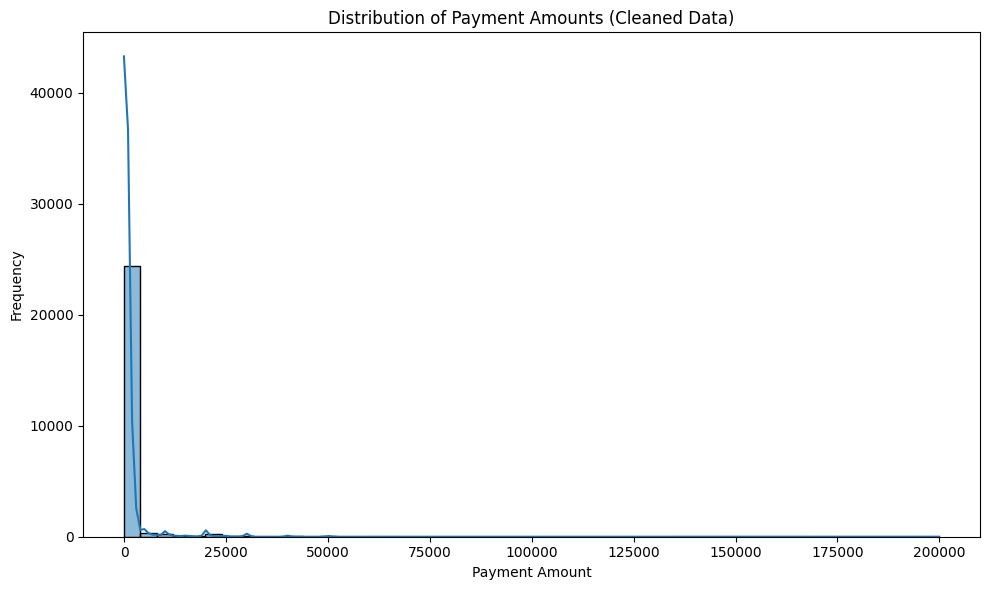

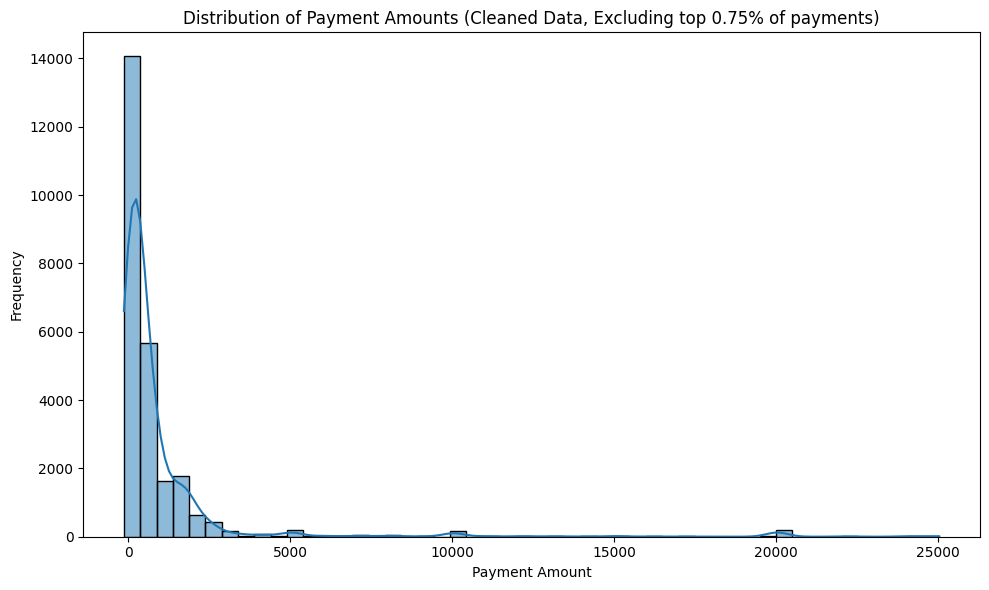

In [ ]:
# Distribution of Payment Amounts
plt.figure(figsize=(10, 6))
sns.histplot(merged_cleaned_df['payment_amt'], bins=50, kde=True)
plt.title('Distribution of Payment Amounts (Cleaned Data)')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('payment_amount_distribution_cleaned.png')
plt.show()

# Without the top 0.75% of payments
upper_limit = merged_cleaned_df['payment_amt'].quantile(0.9925)
filtered_payments = merged_cleaned_df[merged_cleaned_df['payment_amt'] <= upper_limit]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_payments['payment_amt'], bins=50, kde=True)
plt.title('Distribution of Payment Amounts (Cleaned Data, Excluding top 0.75% of payments)')
plt.xlabel('Payment Amount')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('payment_amount_distribution_cleaned_no_outliers.png')
plt.show()


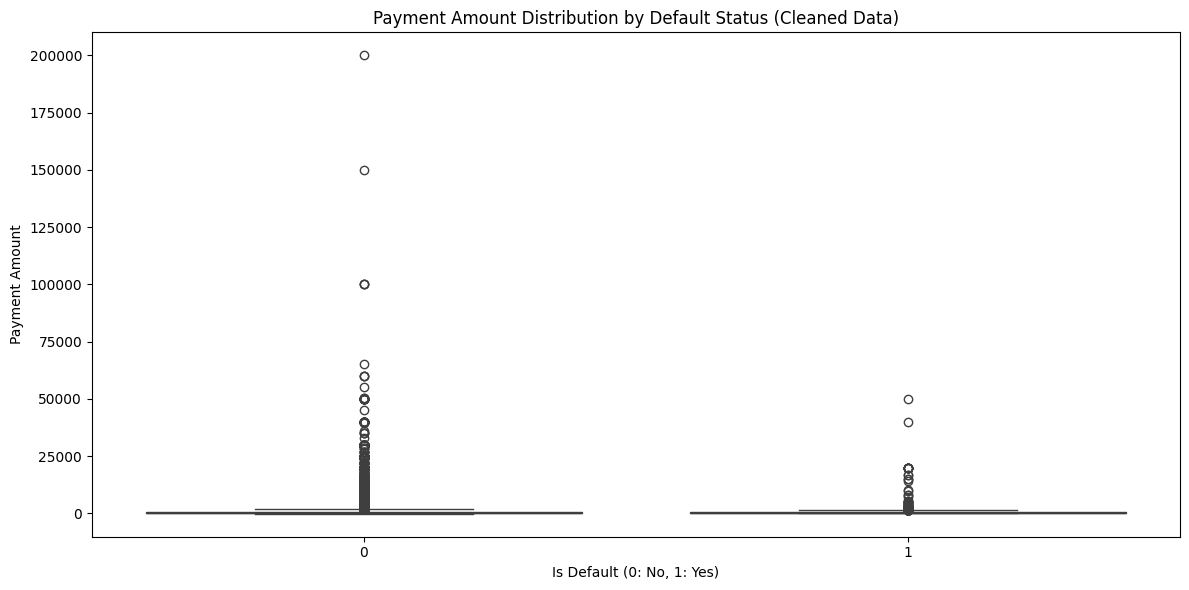

In [49]:
# Distribution of Payment Amounts between those that were defaulted and those that were paid
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_default', y='payment_amt', data=merged_cleaned_df)
plt.title('Payment Amount Distribution by Default Status (Cleaned Data)')
plt.xlabel('Is Default (0: No, 1: Yes)')
plt.ylabel('Payment Amount')
plt.tight_layout()
plt.savefig('payment_amount_by_default_status_cleaned.png')
plt.show()


Default rates by Entity Type (from Cleaned Data):
| entity_type                    | total_transactions   | defaults   | default_rate   |
|:-------------------------------|:---------------------|:-----------|:---------------|
| Discretionary Investment Trust | 59                   | 14         | 23.7288        |
| Australian Public Company      | 128                  | 16         | 12.5           |
| Discretionary Trading Trust    | 187                  | 21         | 11.2299        |
| Individual/Sole Trader         | 9418                 | 901        | 9.56679        |
| Australian Private Company     | 14828                | 1226       | 8.26814        |
| Hybrid Trust                   | 32                   | 2          | 6.25           |
| Family Partnership             | 736                  | 33         | 4.4837         |
| Other Partnership              | 135                  | 6          | 4.44444        |
| Australian Proprietary Company | 4                    | 0          

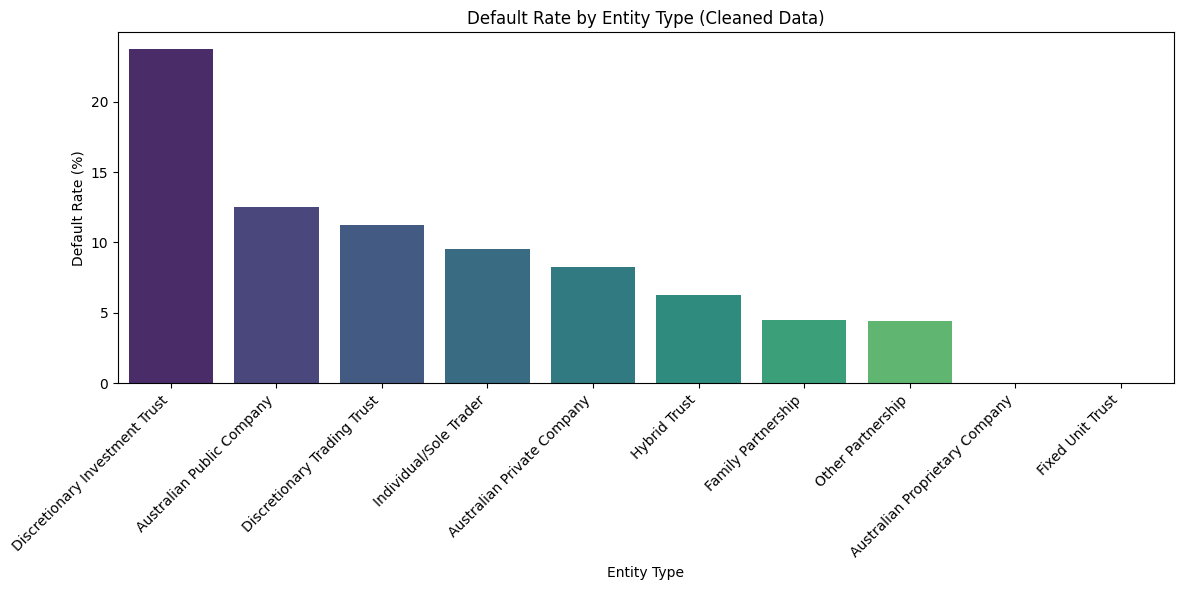

In [63]:
entity_type_defaults_cleaned = merged_cleaned_df.groupby('entity_type').agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
entity_type_defaults_cleaned['default_rate'] = (entity_type_defaults_cleaned['defaults'] / entity_type_defaults_cleaned['total_transactions']) * 100
entity_type_defaults_cleaned = entity_type_defaults_cleaned.sort_values(by='default_rate', ascending=False)

print("\nDefault rates by Entity Type (from Cleaned Data):")
print(entity_type_defaults_cleaned.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(12, 6))
sns.barplot(x='entity_type', y='default_rate', data=entity_type_defaults_cleaned, hue='entity_type', palette='viridis', legend=False)
plt.title('Default Rate by Entity Type (Cleaned Data)')
plt.xlabel('Entity Type')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('default_rate_by_entity_type_cleaned.png')
plt.show()


Default rates by Client Age Group (Cleaned Data):
| client_age_group   | total_transactions   | defaults   | default_rate   |
|:-------------------|:---------------------|:-----------|:---------------|
| 3-4 Years          | 2688                 | 317        | 11.7932        |
| 4-5 Years          | 2326                 | 267        | 11.4789        |
| 2-3 Years          | 2228                 | 253        | 11.3555        |
| 11-12 Years        | 1157                 | 125        | 10.8038        |
| 9-10 Years         | 1063                 | 113        | 10.6303        |
| 5-6 Years          | 1728                 | 176        | 10.1852        |
| 19-20 Years        | 372                  | 31         | 8.33333        |
| 16-17 Years        | 452                  | 37         | 8.18584        |
| 18-19 Years        | 2237                 | 174        | 7.77827        |
| 8-9 Years          | 1080                 | 84         | 7.77778        |
| 6-7 Years          | 1707          

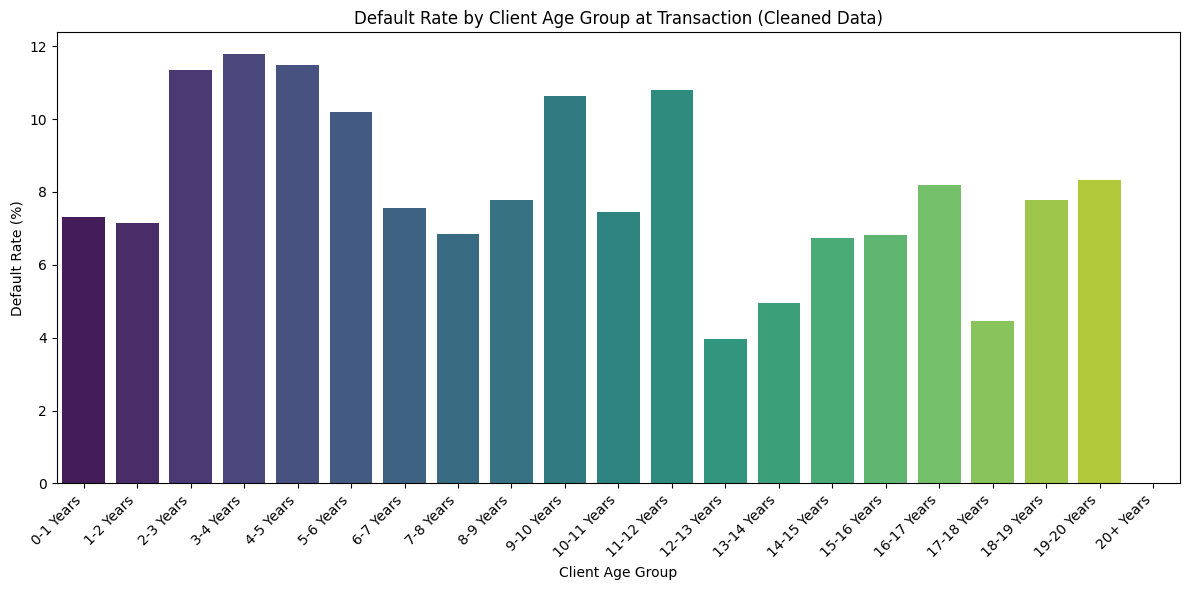

In [65]:
max_year = 20
age_bins = list(range(0, max_year)) + [max_year, float('inf')]
age_labels = [f"{i}-{i+1} Years" for i in range(0, max_year)] + ["20+ Years"]

age_group_defaults_cleaned = merged_cleaned_df.groupby('client_age_group', observed=True).agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
age_group_defaults_cleaned['default_rate'] = (age_group_defaults_cleaned['defaults'] / age_group_defaults_cleaned['total_transactions']) * 100
age_group_defaults_cleaned = age_group_defaults_cleaned.sort_values(by='default_rate', ascending=False)

print("\nDefault rates by Client Age Group (Cleaned Data):")
print(age_group_defaults_cleaned.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(12, 6))
sns.barplot(x='client_age_group', y='default_rate', data=age_group_defaults_cleaned, hue='client_age_group', palette='viridis', legend=False, dodge=False)
plt.title('Default Rate by Client Age Group at Transaction (Cleaned Data)')
plt.xlabel('Client Age Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('default_rate_by_client_age_group_cleaned.png')
plt.show()


Default rates by Client Age Group (Cleaned Data):
| client_age_group   | total_transactions   | defaults   | default_rate   |
|:-------------------|:---------------------|:-----------|:---------------|
| 0-3 Years          | 6241                 | 665        | 10.6553        |
| 4-6 Years          | 5761                 | 572        | 9.92883        |
| 19+ Years          | 372                  | 31         | 8.33333        |
| 7-9 Years          | 3415                 | 284        | 8.31625        |
| 10-12 Years        | 3250                 | 250        | 7.69231        |
| 16-18 Years        | 4369                 | 286        | 6.54612        |
| 13-15 Years        | 2151                 | 131        | 6.09019        |


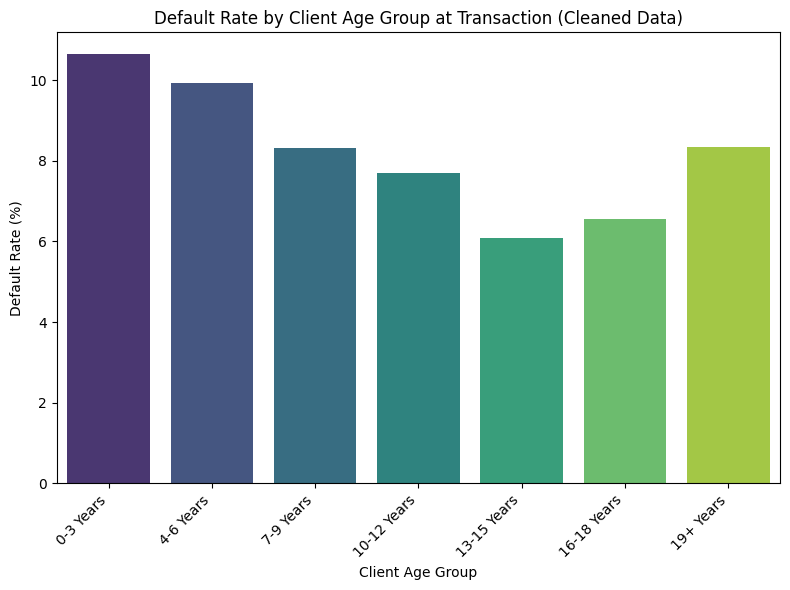

In [68]:
age_bins = [0, 4, 7, 10, 13, 16, 19, float('inf')]
age_labels = ["0-3 Years", "4-6 Years", "7-9 Years", "10-12 Years", "13-15 Years", "16-18 Years", "19+ Years"]

merged_cleaned_df['client_age_group'] = pd.cut(
    merged_cleaned_df['client_age_at_transaction'],
    bins=age_bins,
    labels=age_labels,
    right=False
)

age_group_defaults_cleaned = merged_cleaned_df.groupby('client_age_group', observed=True).agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
age_group_defaults_cleaned['default_rate'] = (age_group_defaults_cleaned['defaults'] / age_group_defaults_cleaned['total_transactions']) * 100
age_group_defaults_cleaned = age_group_defaults_cleaned.sort_values(by='default_rate', ascending=False)

print("\nDefault rates by Client Age Group (Cleaned Data):")
print(age_group_defaults_cleaned.to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(8, 6))
sns.barplot(x='client_age_group', y='default_rate', data=age_group_defaults_cleaned, hue='client_age_group', palette='viridis', legend=False, dodge=False)
plt.title('Default Rate by Client Age Group at Transaction (Cleaned Data)')
plt.xlabel('Client Age Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('default_rate_by_client_age_group_cleaned.png')
plt.show()


Default rates by Month (from Cleaned Data):
| transaction_month   | total_transactions   | defaults   | default_rate   |
|:--------------------|:---------------------|:-----------|:---------------|
| 1                   | 1871                 | 165        | 8.81881        |
| 2                   | 1905                 | 188        | 9.86877        |
| 3                   | 1917                 | 164        | 8.55503        |
| 4                   | 2272                 | 222        | 9.77113        |
| 5                   | 2430                 | 202        | 8.31276        |
| 6                   | 2469                 | 209        | 8.46497        |
| 7                   | 4129                 | 364        | 8.81569        |
| 8                   | 1759                 | 193        | 10.9721        |
| 9                   | 1653                 | 140        | 8.46945        |
| 10                  | 1742                 | 148        | 8.49598        |
| 11                  | 1751   

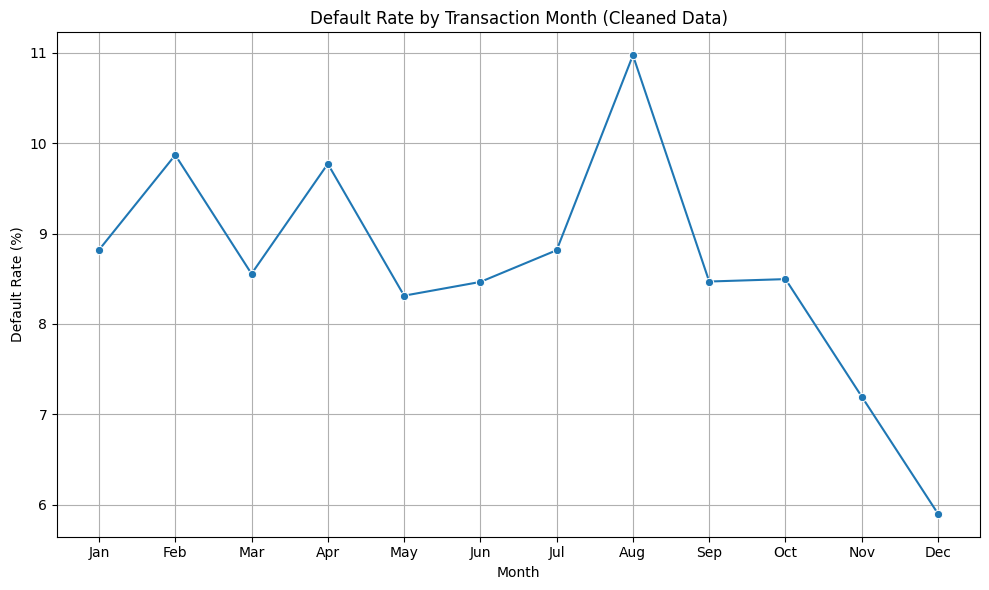


Default rates by Quarter (from Cleaned Data):
| transaction_quarter   | total_transactions   | defaults   | default_rate   |
|:----------------------|:---------------------|:-----------|:---------------|
| 1                     | 5693                 | 517        | 9.08133        |
| 2                     | 7171                 | 633        | 8.82722        |
| 3                     | 7541                 | 697        | 9.24281        |
| 4                     | 5154                 | 372        | 7.21769        |


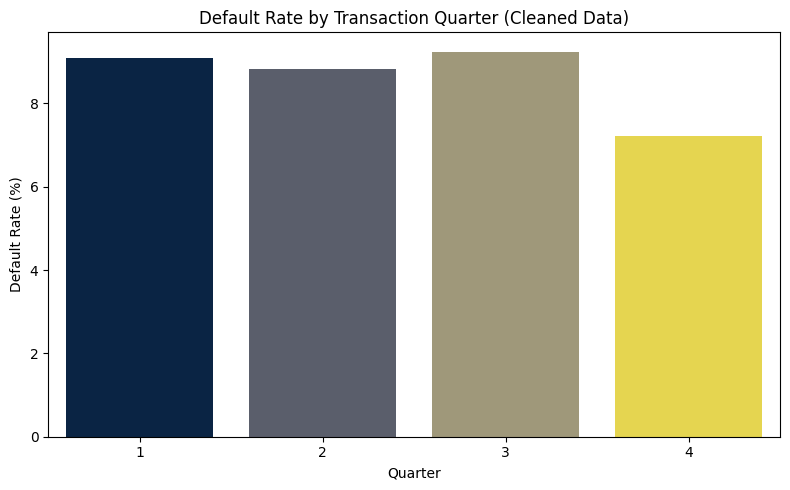

In [73]:
# Temporal Deafults (Month & Quarter)
monthly_defaults_cleaned = merged_cleaned_df.groupby('transaction_month').agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
monthly_defaults_cleaned['default_rate'] = (monthly_defaults_cleaned['defaults'] / monthly_defaults_cleaned['total_transactions']) * 100

print("\nDefault rates by Month (from Cleaned Data):")
print(monthly_defaults_cleaned.sort_values(by='transaction_month').to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(10, 6))
sns.lineplot(x='transaction_month', y='default_rate', data=monthly_defaults_cleaned, marker='o')
plt.title('Default Rate by Transaction Month (Cleaned Data)')
plt.xlabel('Month')
plt.ylabel('Default Rate (%)')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.savefig('default_rate_by_month_cleaned.png')
plt.show()

quarterly_defaults_cleaned = merged_cleaned_df.groupby('transaction_quarter').agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
quarterly_defaults_cleaned['default_rate'] = (quarterly_defaults_cleaned['defaults'] / quarterly_defaults_cleaned['total_transactions']) * 100

print("\nDefault rates by Quarter (from Cleaned Data):")
print(quarterly_defaults_cleaned.sort_values(by='transaction_quarter').to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(8, 5))
sns.barplot(x='transaction_quarter', y='default_rate', data=quarterly_defaults_cleaned, hue='transaction_quarter', palette='cividis', legend=False)
plt.title('Default Rate by Transaction Quarter (Cleaned Data)')
plt.xlabel('Quarter')
plt.ylabel('Default Rate (%)')
plt.tight_layout()
plt.savefig('default_rate_by_quarter_cleaned.png')
plt.show()


Default rates by Payment Lag Group (from Cleaned Data):
| payment_lag_group     | total_transactions   | defaults   | default_rate   |
|:----------------------|:---------------------|:-----------|:---------------|
| 180+ Days             | 5                    | 3          | 60             |
| 91-180 Days           | 12                   | 4          | 33.3333        |
| 1-7 Days              | 3372                 | 1071       | 31.7616        |
| Same Day/Prev Day (0) | 12596                | 1113       | 8.83614        |
| 61-90 Days            | 37                   | 2          | 5.40541        |
| 8-14 Days             | 434                  | 6          | 1.38249        |
| 31-60 Days            | 2757                 | 6          | 0.217628       |
| 15-30 Days            | 4703                 | 3          | 0.0637891      |


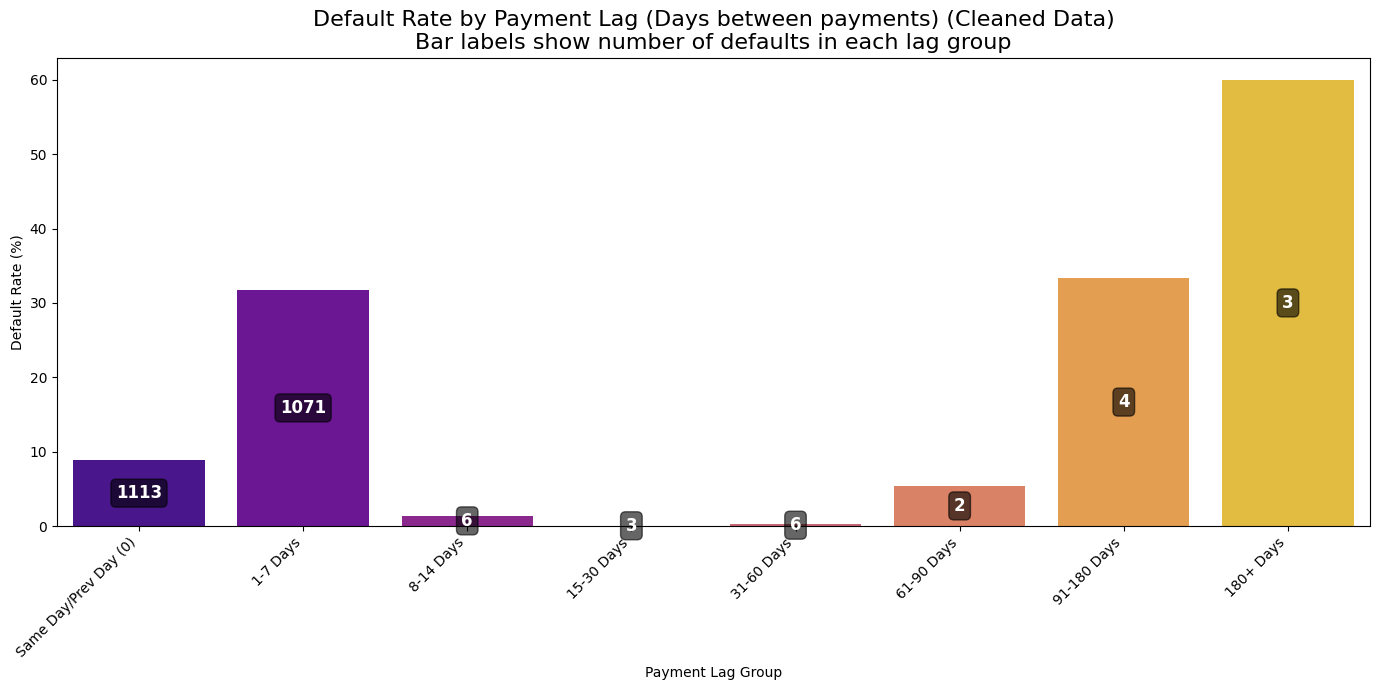

In [100]:
# Default rates by Payment Lag Group
# Create lag bins
lag_bins = [-1, 0, 7, 14, 30, 60, 90, 180, merged_cleaned_df['payment_lag_days'].max() + 1]
lag_labels = ['Same Day/Prev Day (0)', '1-7 Days', '8-14 Days', '15-30 Days', '31-60 Days', '61-90 Days', '91-180 Days', '180+ Days']

# Exclude NaN values from payment_lag_days as they are first payments of a contract
lag_analysis_df_cleaned = merged_cleaned_df.dropna(subset=['payment_lag_days']).copy()
lag_analysis_df_cleaned['payment_lag_group'] = pd.cut(
    lag_analysis_df_cleaned['payment_lag_days'],
    bins=lag_bins,
    labels=lag_labels,
    right=True
)

lag_defaults_cleaned = lag_analysis_df_cleaned.groupby('payment_lag_group', observed=False).agg(
    total_transactions=('is_default', 'count'),
    defaults=('is_default', 'sum')
).reset_index()
lag_defaults_cleaned['default_rate'] = (lag_defaults_cleaned['defaults'] / lag_defaults_cleaned['total_transactions']) * 100

print("\nDefault rates by Payment Lag Group (from Cleaned Data):")
print(lag_defaults_cleaned.sort_values(by='default_rate', ascending=False).to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x='payment_lag_group',
    y='default_rate',
    data=lag_defaults_cleaned,
    hue='payment_lag_group',
    palette='plasma'
)
plt.title('Default Rate by Payment Lag (Days between payments) (Cleaned Data)\nBar labels show number of defaults in each lag group', fontsize=16)
plt.xlabel('Payment Lag Group')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate each bar with the raw frequency (defaults)
for i, row in lag_defaults_cleaned.iterrows():
    ax.text(
        i,
        row['default_rate'] / 2,
        f"{int(row['defaults'])}",
        ha='center', va='center',
        color='white', fontweight='bold', fontsize=12,
        bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3')
    )

plt.savefig('default_rate_by_payment_lag_cleaned.png')
plt.show()

## ⚒️ Refining Data

The conditions for a "rectified" payment:
1. Current transaction's original payment_code is 'DEFAULT'
2. Next payment exists (not NaN for next_payment_code_cc)
3. Next payment's 'is_default' status is 0 (meaning it was successful/non-default)
4. Next payment's amount is the same as the current payment's amount

In [107]:
import numpy as np


Number of rectifying payments by hour after a defaulted payment (first 20 rows):
| hours_to_next_rounded   | num_rectifying_payments   |
|:------------------------|:--------------------------|
| 0                       | 51                        |
| 24                      | 30                        |
| 48                      | 8                         |
| 72                      | 17                        |
| 96                      | 12                        |
| 120                     | 9                         |
| 143                     | 1                         |
| 144                     | 112                       |
| 168                     | 40                        |
| 169                     | 4                         |
| 192                     | 5                         |
| 193                     | 2                         |
| 216                     | 3                         |
| 240                     | 4                         |
| 241                 

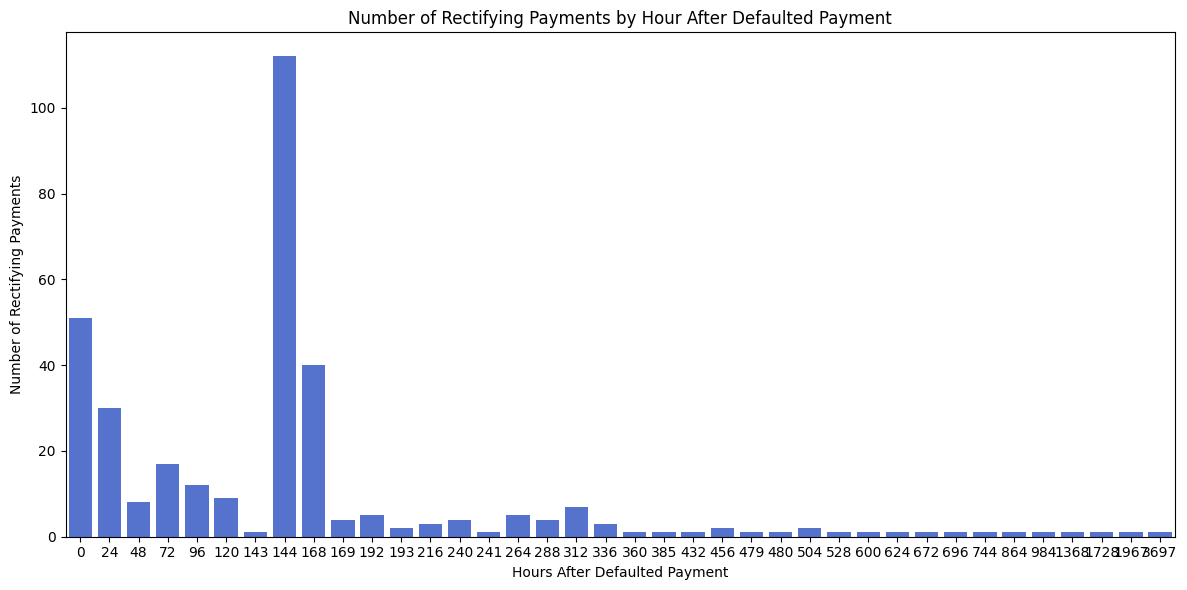

In [ ]:
merged_df_rectify_hour = merged_cleaned_df.copy()
merged_df_rectify_hour.sort_values(by=['client_id', 'contract_id', 'transaction_date'], inplace=True)

# Create next transaction columns within each client-contract group
merged_df_rectify_hour['next_payment_code_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['payment_code'].shift(-1)
merged_df_rectify_hour['next_transaction_date_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['transaction_date'].shift(-1)
merged_df_rectify_hour['next_payment_amt_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['payment_amt'].shift(-1)
merged_df_rectify_hour['next_is_default_cc'] = merged_df_rectify_hour.groupby(['client_id', 'contract_id'])['is_default'].shift(-1)

# Calculate time difference to next transaction in hours
merged_df_rectify_hour['hours_to_next'] = (
    (merged_df_rectify_hour['next_transaction_date_cc'] - merged_df_rectify_hour['transaction_date']).dt.total_seconds() / 3600
)

# Only consider rows where current payment is DEFAULT and next payment is a successful rectification (same amount, not default)
rectified_mask = (
    (merged_df_rectify_hour['payment_code'] == 'DEFAULT') &
    (merged_df_rectify_hour['next_payment_code_cc'].notna()) &
    (merged_df_rectify_hour['next_is_default_cc'] == 0) &
    (merged_df_rectify_hour['next_payment_amt_cc'] == merged_df_rectify_hour['payment_amt'])
)

rectified_df = merged_df_rectify_hour[rectified_mask].copy()
rectified_df['hours_to_next_rounded'] = rectified_df['hours_to_next'].round().astype(int)

# Count number of rectifying payments for each hour after a default
rectify_hour_counts = rectified_df.groupby('hours_to_next_rounded').size().reset_index(name='num_rectifying_payments')

print("\nNumber of rectifying payments by hour after a defaulted payment (first 20 rows):")
print(rectify_hour_counts.head(20).to_markdown(index=False, numalign="left", stralign="left"))

plt.figure(figsize=(12, 6))
sns.barplot(x='hours_to_next_rounded', y='num_rectifying_payments', data=rectify_hour_counts, color='royalblue')
plt.title('Number of Rectifying Payments by Hour After Defaulted Payment')
plt.xlabel('Hours After Defaulted Payment')
plt.ylabel('Number of Rectifying Payments')
plt.tight_layout()
plt.savefig('rectifying_payments_by_hour.png')
plt.show()

In [116]:
# Create a copy of merged_cleaned_df to work on for the second round of analysis
merged_df_round2 = merged_cleaned_df.copy()

print("Created `merged_df_round2` as a copy of `merged_cleaned_df` for further enrichment.")
print(f"Initial shape of `merged_df_round2`: {merged_df_round2.shape}")

# Ensure the DataFrame is sorted by client_id, contract_id, and transaction_date
# This is crucial for accurate 'shift' operations within groups
merged_df_round2.sort_values(by=['client_id', 'contract_id', 'transaction_date'], inplace=True)

# Create temporary columns for the *next* transaction's details within the same client-contract pair
merged_df_round2['next_payment_code_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['payment_code'].shift(-1)
merged_df_round2['next_transaction_date_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['transaction_date'].shift(-1)
merged_df_round2['next_payment_amt_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['payment_amt'].shift(-1)
merged_df_round2['next_is_default_cc'] = merged_df_round2.groupby(['client_id', 'contract_id'])['is_default'].shift(-1) # Use the already refined is_default


# Calculate the time difference to the next transaction for the same client-contract pair
merged_df_round2['time_to_next_transaction_cc'] = merged_df_round2['next_transaction_date_cc'] - merged_df_round2['transaction_date']

# Convert timedelta to total hours
merged_df_round2['hours_to_next_cc'] = merged_df_round2['time_to_next_transaction_cc'].dt.total_seconds() / 3600


# Define the conditions for a "rectified" payment
# 1. Current transaction's original payment_code is 'DEFAULT'
# 2. Next payment exists (not NaN for next_payment_code_cc)
# 3. Next payment's 'is_default' status is 0 (meaning it was successful/non-default after initial refinement)
# 4. Next payment's amount is the same as the current payment's amount
rectified_conditions = (
    (merged_df_round2['payment_code'] == 'DEFAULT') & # Check original payment_code for DEFAULT
    (merged_df_round2['next_payment_code_cc'].notna()) & # Ensure there is a next payment
    (merged_df_round2['next_is_default_cc'] == 0) & # The next payment was not a default (after initial refinement)
    (merged_df_round2['next_payment_amt_cc'] == merged_df_round2['payment_amt']) # Amounts match
)

# Initialize the new column 'hours_until_rectified'
# For transactions that are NOT defaults or don't meet rectification criteria, set to np.inf
merged_df_round2['hours_until_rectified'] = np.inf

# For transactions that ARE defaults and meet the rectification criteria, set to the calculated hours
merged_df_round2.loc[rectified_conditions, 'hours_until_rectified'] = \
    merged_df_round2.loc[rectified_conditions, 'hours_to_next_cc']

num_rectified_defaults_round2 = merged_df_round2[merged_df_round2['hours_until_rectified'] != np.inf].shape[0]
print(f"\nCreated 'hours_until_rectified' flag.")
print(f"Found {num_rectified_defaults_round2} instances of defaults that were rectified with matching amounts.")
print("For non-rectified defaults or non-default transactions, 'hours_until_rectified' is set to infinity (np.inf).")


# Clean up the temporary columns
merged_df_round2.drop(columns=[
    'next_payment_code_cc',
    'next_transaction_date_cc',
    'next_payment_amt_cc',
    'next_is_default_cc',
    'time_to_next_transaction_cc',
    'hours_to_next_cc'
], inplace=True, errors='ignore')

print("\n`merged_df_round2` after adding 'hours_until_rectified' flag - first 10 rows:")
# Display relevant columns to confirm the new flag
display_cols_flag_round2 = [
    'client_id', 'contract_id', 'transaction_date', 'payment_code', 'payment_amt', 'is_default',
    'hours_until_rectified'
]
print(merged_df_round2[display_cols_flag_round2].head(10).to_markdown(index=False, numalign="left", stralign="left"))

rectified_payments_only = merged_df_round2[merged_df_round2['hours_until_rectified'] != np.inf]

if not rectified_payments_only.empty:
    max_rectification_hours = rectified_payments_only['hours_until_rectified'].max()

    # Convert total hours into days and remaining hours
    max_days = int(max_rectification_hours // 24)
    max_remaining_hours = max_rectification_hours % 24

    print(f"\nMaximum rectification time observed: {max_days} days and {max_remaining_hours:.2f} hours.")
else:
    print("\nNo rectified payments found to calculate maximum rectification time.")

Created `merged_df_round2` as a copy of `merged_cleaned_df` for further enrichment.
Initial shape of `merged_df_round2`: (25559, 16)

Created 'hours_until_rectified' flag.
Found 339 instances of defaults that were rectified with matching amounts.
For non-rectified defaults or non-default transactions, 'hours_until_rectified' is set to infinity (np.inf).

`merged_df_round2` after adding 'hours_until_rectified' flag - first 10 rows:
| client_id   | contract_id   | transaction_date    | payment_code   | payment_amt   | is_default   | hours_until_rectified   |
|:------------|:--------------|:--------------------|:---------------|:--------------|:-------------|:------------------------|
| 1           | 927           | 2017-11-22 17:08:16 | PAYMENT        | 5050.04       | 0            | inf                     |
| 1           | 927           | 2017-11-22 17:08:16 | PAYMENT        | 50            | 0            | inf                     |
| 1           | 927           | 2017-11-26 17:08:15 |

In [ ]:
constant_hours_threshold = 144

# Filter for rectified payments that are within the specified constant_hours_threshold
rectified_within_threshold = merged_df_round2[
    (merged_df_round2['hours_until_rectified'] != np.inf) &
    (merged_df_round2['hours_until_rectified'] <= constant_hours_threshold)
]

num_rectified_payments_within_threshold = rectified_within_threshold.shape[0]

print(f"\nNumber of rectifying payments that happened within {constant_hours_threshold} hours: {num_rectified_payments_within_threshold}")


Number of rectifying payments that happened within 144 hours: 159
